In [47]:
import requests
import pandas as pd
import math
import os
import matplotlib.pyplot as plt


In [57]:
os.environ['ALPHA_VANTAGE_API_KEY'] = 'XXXX'
os.environ['FINHUB_API_KEY'] = 'xxxxx'
symbol = 'NRDS'
target_profit_price = 9.34
interval = 'daily'  # Specify the desired interval ('intraday', 'daily', 'weekly')
start_date = '2023-01-01'  # Specify the start date for historical data
buy_signal = False

In [58]:
def get_current_stock_price(api_key, symbol):
    url = f"https://finnhub.io/api/v1/quote?symbol={symbol}&token={api_key}"
    response = requests.get(url)
    print(response)
    data = response.json()
    return data['c']  # Current price

finnhub_api_key=os.environ['FINHUB_API_KEY']
current_price = get_current_stock_price(finnhub_api_key, symbol)


<Response [200]>


In [59]:
def calculate_fibonacci_retracements(high, low):
    # Adjust the Fibonacci ratios as needed
    fibonacci_ratios = [0.236, 0.382, 0.5, 0.618, 0.786]  # Example adjusted ratios
    fibonacci_retracements = []
    for i in range(40):
        fibonacci_level = round((i+1)/(len(fibonacci_ratios)+1), 2) * fibonacci_ratios[i % len(fibonacci_ratios)]
        fibonacci_retracements.append(fibonacci_level)
    fibonacci_levels = {}
    for r in fibonacci_retracements:
        fibonacci_levels[f"{r * 100:.0f}%"] = round((low + high) - ((high - low) * r), 2)
    return fibonacci_levels


In [60]:
from alpha_vantage.timeseries import TimeSeries

def fetch_historical_data(symbol, interval, output_size='compact', start_date=None):
    # Replace with your AlphaVantage API key
    api_key = os.environ['ALPHA_VANTAGE_API_KEY'] 

    # Initialize the TimeSeries object
    ts = TimeSeries(key=api_key, output_format='json')

    # Map interval to the corresponding AlphaVantage function name
    interval_mapping = {
        'intraday': 'TIME_SERIES_INTRADAY',
        'daily': 'TIME_SERIES_DAILY',
        'weekly': 'TIME_SERIES_WEEKLY'
    }

    if interval not in interval_mapping:
        raise ValueError("Invalid interval. Supported intervals: 'intraday', 'daily', 'weekly'")

    # Define the function name based on the interval
    function_name = interval_mapping[interval]

    if interval == 'intraday':
        # Adjust the interval as needed
        interval = '5min'
    
    # Fetch historical data
    if interval == 'daily':
        historical_data, meta_data = ts.get_daily_adjusted(symbol=symbol, outputsize=output_size)
    elif interval == 'weekly':
        historical_data, meta_data = ts.get_weekly_adjusted(symbol=symbol)
    else:
        # For intraday, you can specify the interval (e.g., '5min')
        historical_data, meta_data = ts.get_intraday(symbol=symbol, interval=interval, outputsize=output_size)

    return historical_data


In [61]:
import numpy as np

def calculate_support_resistance_levels(symbol, interval='weekly', output_size='compact'):
    # Fetch historical price data from AlphaVantage
    historical_data = fetch_historical_data(symbol, interval, output_size)
    
    # Extract closing prices from historical data
    closing_prices = [float(data['4. close']) for data in historical_data.values()]
    print("Display historyical data")
    print(closing_prices)

    # Calculate moving averages (e.g., 50-day and 200-day)
    moving_average_50 = np.mean(closing_prices[-50:])
    moving_average_200 = np.mean(closing_prices[-200:])
    
    # Calculate support and resistance levels
    # You can customize your logic for defining these levels based on moving averages
    # For example, support could be defined as the 50-day moving average, and resistance could be the 200-day moving average
    support_level = moving_average_50
    resistance_level = moving_average_200
    
    return support_level, resistance_level


In [62]:
def calculate_entry_exit_points(current_price, target_price, risk_percentage, account_balance, swing_high, swing_low, buy_signal=True):
    print(current_price, target_price, risk_percentage, account_balance, swing_high, swing_low, buy_signal)
    # Calculate Fibonacci levels
    fibonacci_levels = calculate_fibonacci_retracements(swing_high, swing_low)
    

    # Calculate support and resistance levels
    support_level, resistance_level = calculate_support_resistance_levels(symbol, interval, start_date)

    # Calculate entry and stop loss based on support and resistance
    entry_point, stop_loss = calculate_entry_stop_loss(support_level, resistance_level, buy_signal)

    # Calculate position size based on risk percentage and account balance
    position_size = (risk_percentage / 100) * account_balance

    # Calculate take profit based on Fibonacci levels and target price
    take_profit, closest_levels = calculate_take_profit(target_price, fibonacci_levels, buy_signal)

    # Calculate profit in dollars for take profit and stop loss
    if buy_signal:
        profit_take_profit = (take_profit - entry_point) * position_size
        profit_stop_loss = (entry_point - stop_loss) * position_size
    else:
        profit_take_profit = (entry_point - take_profit) * position_size
        profit_stop_loss = (stop_loss - entry_point) * position_size

    # Determine buy/sell flag
    buy_sell_flag = "Buy" if buy_signal else "Sell"

    return {
        'entry': entry_point,
        'stop_loss': stop_loss,
        'take_profit': take_profit,
        'position_size': position_size,
        'profit_take_profit': profit_take_profit,
        'profit_stop_loss': profit_stop_loss,
        'fibonacci_levels': fibonacci_levels,
        'closest_levels': closest_levels,
        'buy_sell_flag': buy_sell_flag
    }

def calculate_entry_stop_loss(support_level, resistance_level, buy_signal):
    # Calculate entry and stop loss based on support and resistance
    if buy_signal:
        entry_point = support_level
        stop_loss = entry_point - (entry_point * 0.02)  # Adjust the percentage as needed
    else:
        entry_point = resistance_level
        stop_loss = entry_point + (entry_point * 0.02)  # Adjust the percentage as needed
    return entry_point, stop_loss

def calculate_take_profit(target_price, fibonacci_levels, buy_signal):
    # Calculate take profit based on Fibonacci levels and target price
    if buy_signal:
        closest_levels = {k: v for k, v in fibonacci_levels.items() if v > target_price}
    else:
        closest_levels = {k: v for k, v in fibonacci_levels.items() if v < target_price}

    take_profit_fibonacci_level = max(closest_levels.keys())
    take_profit = closest_levels[take_profit_fibonacci_level]

    return take_profit, closest_levels



In [63]:
def get_swing_high_low(symbol, interval, start_date):
    print(symbol, interval, start_date)
    # Fetch historical price data from AlphaVantage
    historical_data = fetch_historical_data(symbol,interval, start_date=start_date)
    print("prining historical data")
    print(historical_data)

    # Initialize variables to store swing high and swing low prices
    swing_high = None
    swing_low = None

    # Iterate through historical data to find swing high and swing low
    for date, price_data in historical_data.items():
        high_price = float(price_data['2. high'])
        low_price = float(price_data['3. low'])

        if swing_high is None or high_price > swing_high:
            swing_high = high_price

        if swing_low is None or low_price < swing_low:
            swing_low = low_price

    return swing_high, swing_low


In [64]:
# Example usage
start_date = '2023-01-01' 
swing_high, swing_low = get_swing_high_low(symbol, 'weekly', start_date)
print(f"Swing High: {swing_high}, Swing Low: {swing_low}")
risk_percentage = 1
account_balance = 10000

entry_exit_points = calculate_entry_exit_points(current_price=current_price, target_price=target_profit_price, risk_percentage=1, account_balance=10000, swing_high=swing_high, swing_low=swing_low,buy_signal=buy_signal)

# Printing the output
print("Current Price:", current_price)
print("Price Target:", target_profit_price)
print("Entry Price:", entry_exit_points['entry'])
print("Stop Loss:", entry_exit_points['stop_loss'])
print("Take Profit:", entry_exit_points['take_profit'])
print("Position Size:", entry_exit_points['position_size'])
print("Profit (Take Profit): $", entry_exit_points['profit_take_profit'])
print("Profit (Stop Loss): $", entry_exit_points['profit_stop_loss'])
print("Fibonacci Levels:", entry_exit_points['fibonacci_levels'])
# Print the closest levels and their associated prices for debugging
if buy_signal:
    print(f"Closest levels for Buy (targeting {target_profit_price}): {entry_exit_points['closest_levels']}")
else:
    print(f"Closest levels for Sell (targeting {target_profit_price}): {entry_exit_points['closest_levels']}")
print("Buy/Sell Flag:", entry_exit_points['buy_sell_flag'])

DPSI weekly 2023-01-01


prining historical data
{'2024-02-13': {'1. open': '7.3100', '2. high': '7.6900', '3. low': '7.3100', '4. close': '7.5900', '5. adjusted close': '7.5900', '6. volume': '18585', '7. dividend amount': '0.0000'}, '2024-02-09': {'1. open': '6.9100', '2. high': '8.0700', '3. low': '6.9100', '4. close': '7.4000', '5. adjusted close': '7.4000', '6. volume': '95886', '7. dividend amount': '0.0000'}, '2024-02-02': {'1. open': '6.5000', '2. high': '7.0000', '3. low': '6.0800', '4. close': '6.9900', '5. adjusted close': '6.9900', '6. volume': '59816', '7. dividend amount': '0.0000'}, '2024-01-26': {'1. open': '6.5750', '2. high': '6.5978', '3. low': '6.2500', '4. close': '6.5429', '5. adjusted close': '6.5429', '6. volume': '15787', '7. dividend amount': '0.0000'}, '2024-01-19': {'1. open': '6.4400', '2. high': '6.7500', '3. low': '6.3500', '4. close': '6.5950', '5. adjusted close': '6.5950', '6. volume': '20563', '7. dividend amount': '0.0000'}, '2024-01-12': {'1. open': '6.4700', '2. high': '6.

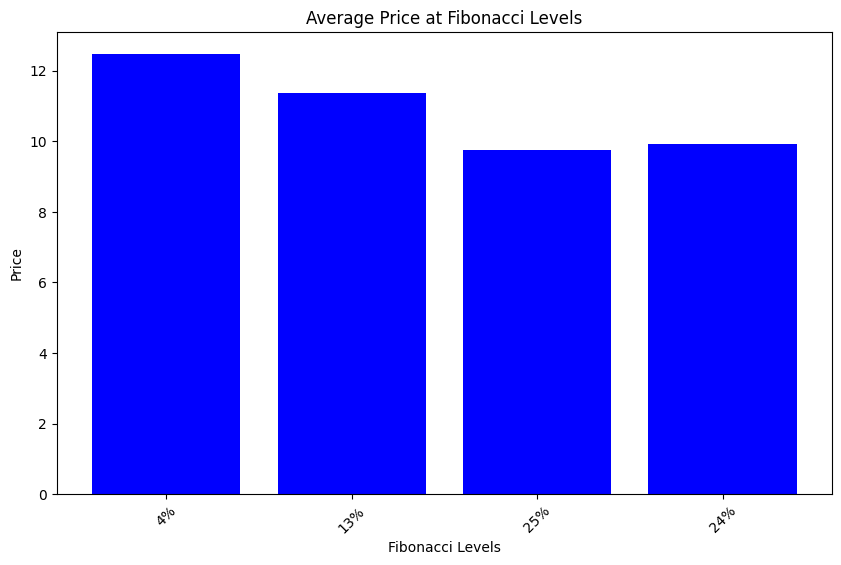

{'4%': 12.47, '13%': 11.36, '25%': 9.75, '24%': 9.93}
Property: 4%, Value: 12.47
Property: 13%, Value: 11.36
Property: 25%, Value: 9.75
Property: 24%, Value: 9.93


In [65]:
# Print the structure of entry_exit_points['closest_levels']

# Extract levels and prices from entry_exit_points['closest_levels'] dictionary
levels = list(entry_exit_points['closest_levels'].keys())
prices = list(entry_exit_points['closest_levels'].values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(levels, prices, color='blue' if buy_signal else 'red')
plt.xlabel("Fibonacci Levels")
plt.ylabel("Price")
plt.title("Average Price at Fibonacci Levels")
plt.xticks(rotation=45)

# Show the chart
plt.show()

print(entry_exit_points['closest_levels'])
for key, value in entry_exit_points['closest_levels'].items():
    print(f"Property: {key}, Value: {value}")
# Check if it's a buy or sell signal and adjust the title accordingly
if buy_signal:
    title = f"Closest Levels for Buy (targeting {target_profit_price})"
else:
    title = f"Closest Levels for Sell (targeting {target_profit_price})"

